### Part 0 - Importing the libraries

In [ ]:
!pip install wget
!pip install mkdir
# !pip install keras-tuner --upgrade

**Enabling GPU**

In [ ]:
# checking if GPU is enabled
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# different devices used during the execution of the notebook
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14518843282636263175
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14385217536
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17166058724053302796
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
# checking RAM
!cat /proc/meminfo

MemTotal:       13297200 kB
MemFree:         7069768 kB
MemAvailable:   10803316 kB
Buffers:          343680 kB
Cached:          3564432 kB
SwapCached:            0 kB
Active:           733832 kB
Inactive:        5077296 kB
Active(anon):       1064 kB
Inactive(anon):  1891204 kB
Active(file):     732768 kB
Inactive(file):  3186092 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               796 kB
Writeback:             0 kB
AnonPages:       1903048 kB
Mapped:           749960 kB
Shmem:             11564 kB
KReclaimable:     112276 kB
Slab:             155728 kB
SReclaimable:     112276 kB
SUnreclaim:        43452 kB
KernelStack:        5952 kB
PageTables:        29504 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6648600 kB
Committed_AS:    4343076 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       78400 kB
VmallocChunk:          0 kB
Percpu:          

In [ ]:
!nvidia-smi

Mon Mar  6 10:28:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    29W /  70W |    333MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Or enabling TPU**

In [ ]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.11.0
Running on TPU  ['10.88.184.2:8470']


In [ ]:
import warnings
warnings.filterwarnings("ignore")

# file extraction libraries
import os
import glob
import zipfile
from pathlib import Path

# input manipulation libraries
import random
import pandas as pd
import numpy as np

# deep learning libraries
import tensorflow as tf
import keras

# model - architecture
from keras.applications.vgg16 import VGG16
from keras.applications import ResNet50

# model - image input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
from keras.utils import load_img
from tensorflow.keras.preprocessing import image

# model - layers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.layers import AveragePooling2D, BatchNormalization

# model - optimizers
from keras.optimizers import Adam

# model - training
from keras.callbacks import ModelCheckpoint
# import kerastuner as kt

# model - performance metrics
from sklearn.metrics import classification_report, confusion_matrix

# visualisation libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn

### Part 1 - Data Preprocessing

**Importing from AWS**

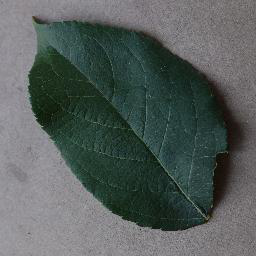

In [ ]:
img = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/new-plant-diseases-dataset/train/Apple___healthy/14284447-1510-439f-bb04-8977e8fa8cbb___RS_HL 6257.JPG")
img

**Training & Testing dataset - directories**

In [ ]:
train_dir = "/content/drive/MyDrive/new-plant-diseases-dataset/train/"
test_dir = "/content/drive/MyDrive/new-plant-diseases-dataset/valid/"

**Extracting the files from the path**

In [ ]:
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count = 0
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count += len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count

In [ ]:
train_samples = get_files(train_dir)
num_classes = len(glob.glob(train_dir+"/*"))
test_samples = get_files(test_dir)

print(num_classes, "Classes")
print(train_samples, "Train images")
print(test_samples, "Test images")

38 Classes
38000 Train images
9500 Test images


**Importing the image files (Train + Test)**

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   validation_split = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
img_width,img_height = 256,256
input_shape = (img_width,img_height,3)
batch_size = 32

In [ ]:
training_dataset = train_datagen.flow_from_directory(train_dir,
                                                   target_size = (img_width,img_height),
                                                   batch_size = batch_size)

testing_dataset = test_datagen.flow_from_directory(test_dir,
                                                   shuffle = True,
                                                   target_size = (img_width,img_height),
                                                   batch_size = batch_size)

Found 38000 images belonging to 38 classes.
Found 9500 images belonging to 38 classes.


**Visualising one of the images imported**

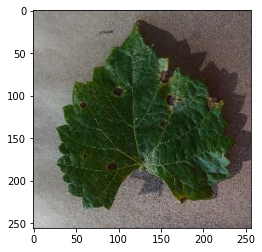

In [ ]:
img = load_img(test_dir+'Grape___Black_rot/0434878b-1f52-496a-87c6-58647824ee2d___FAM_B.Rot 5035.JPG',
               target_size=(img_width,img_height))
plt.imshow(img);
img = image.img_to_array(img)
img = img/255
img = np.expand_dims(img, axis=0)

### Part 2 - Creating our own model + Transfer Learning

**VGG16 -  Architecture**

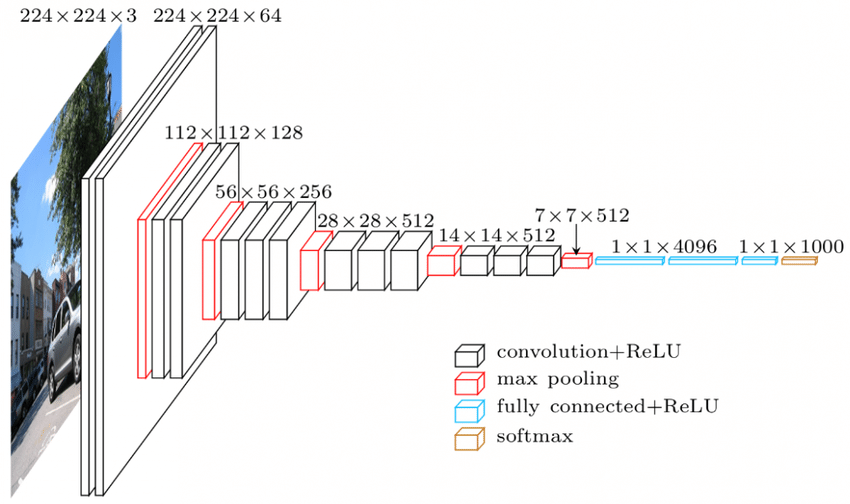

**Loading a saved model (If already trained and saved)**

In [ ]:
save_dir = "/content/drive/MyDrive/"

classifier = tf.keras.models.load_model(save_dir+"disease_vgg.h5")
print("Model successfully loaded!\n")

classifier.summary()

**Importing the VGG16 model**

In [ ]:
base_model = VGG16(include_top = False, input_shape=input_shape)
base_model.trainable = False

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
classifier=keras.models.Sequential()
classifier.add(base_model)
classifier.add(Flatten())
classifier.add(Dense(num_classes,activation='softmax'))
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 38)                1245222   
                                                                 
Total params: 15,959,910
Trainable params: 1,245,222
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
save_dir = "/content/drive/MyDrive/"

classifier.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint = ModelCheckpoint(save_dir+'disease_vgg.h5',
                             monitor = 'val_loss',
                             save_best_only = True,
                             save_weights_only = True,
                             verbose = 1)

In [ ]:
epochs = 5

history_vgg = classifier.fit(training_dataset,
                              validation_data = testing_dataset,
                              epochs = epochs,
                              batch_size = batch_size,
                              # callbacks = [checkpoint],
                              verbose = 1)

Epoch 1/5
1188/1188 [==============================] - 743s 625ms/step - loss: 0.2108 - accuracy: 0.9637 - val_loss: 0.3671 - val_accuracy: 0.9488
Epoch 2/5
1188/1188 [==============================] - 726s 611ms/step - loss: 0.1967 - accuracy: 0.9655 - val_loss: 0.4231 - val_accuracy: 0.9453
Epoch 3/5
1188/1188 [==============================] - 724s 609ms/step - loss: 0.2191 - accuracy: 0.9649 - val_loss: 0.4033 - val_accuracy: 0.9524
Epoch 4/5
1188/1188 [==============================] - 722s 607ms/step - loss: 0.1973 - accuracy: 0.9692 - val_loss: 0.5668 - val_accuracy: 0.9405
Epoch 5/5
1188/1188 [==============================] - 748s 630ms/step - loss: 0.1752 - accuracy: 0.9705 - val_loss: 0.4273 - val_accuracy: 0.9498


**Save the trained model**

In [ ]:
# model already saved - using ModelCheckpoint

# save the VGG model
tf.keras.models.save_model(classifier, save_dir+'disease_vgg_wo_checkp.h5')

print("Model successfully saved!")

Model successfully saved!


## Part 3 - Visualisation

**Feature Maps used by the model during training**

In [ ]:
# Summary of the base model - untrained VGG16
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

**Convolutional Layer - Block 1**

1/1 [==============================] - 0s 293ms/step
Convolution Layer - Block 1


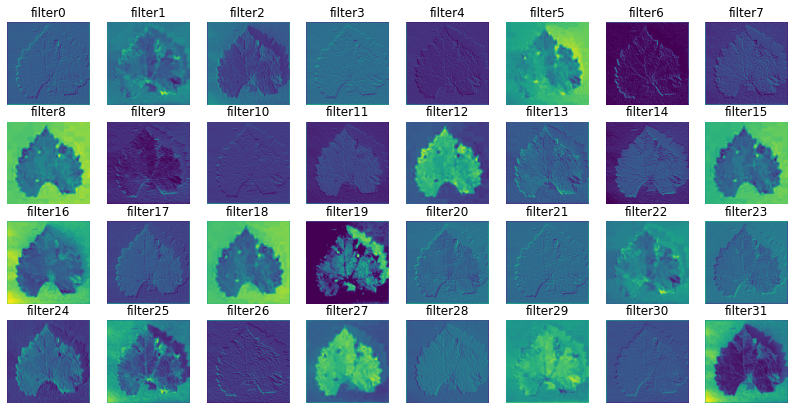

In [ ]:
# creating a layer object
block1_conv1_output = Model(inputs = base_model.input,
                         outputs = base_model.get_layer('block1_conv1').output)
block1_conv1_features = block1_conv1_output.predict(img)

fig = plt.figure(figsize = (14,7))
columns = 8
rows = 4

print("Convolution Layer - Block 1")
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(block1_conv1_features[0, :, :, i], cmap = 'viridis')
plt.show()

**Convolutional Layer - Block 2**

1/1 [==============================] - 1s 503ms/step
Convolution Layer - Block 2


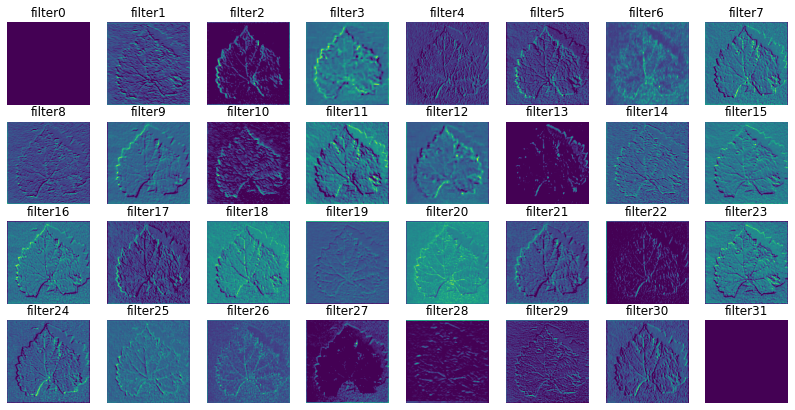

In [ ]:
block2_conv1_output = Model(inputs = base_model.input,
                         outputs = base_model.get_layer('block2_conv1').output)
block2_conv1_features = block2_conv1_output.predict(img)

fig = plt.figure(figsize = (14,7))

print("Convolution Layer - Block 2")
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(block2_conv1_features[0, :, :, i], cmap = 'viridis')
plt.show()

**Convolutional Layer - Block 3**

1/1 [==============================] - 1s 830ms/step
Convolution Layer - Block 3


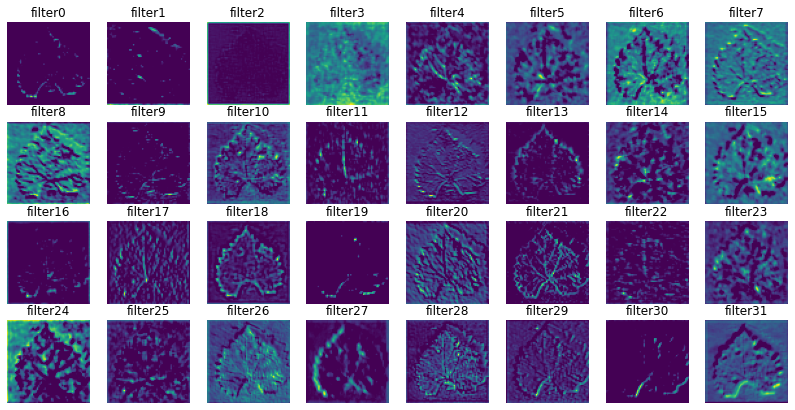

In [ ]:
block3_conv1_output = Model(inputs = base_model.input,
                         outputs = base_model.get_layer('block3_conv1').output)
block3_conv1_features = block3_conv1_output.predict(img)

fig = plt.figure(figsize = (14,7))

print("Convolution Layer - Block 3")
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(block3_conv1_features[0, :, :, i], cmap = 'viridis')
plt.show()

**Convolutional Layer - Block 4**

1/1 [==============================] - 1s 725ms/step
Convolution Layer - Block 4


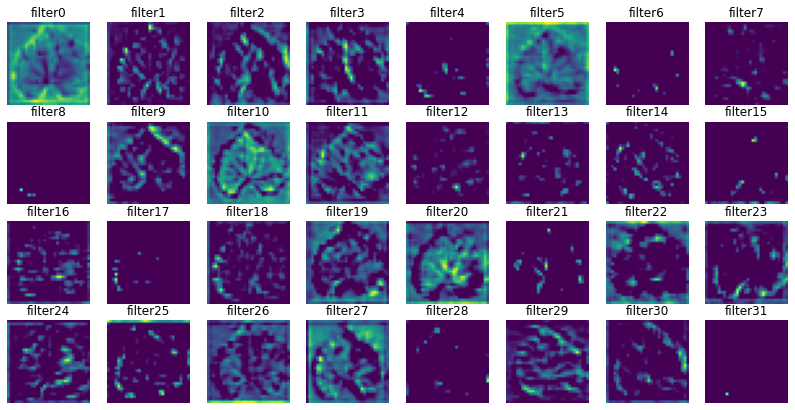

In [ ]:
block4_conv1_output = Model(inputs = base_model.input,
                         outputs = base_model.get_layer('block4_conv1').output)
block4_conv1_features = block4_conv1_output.predict(img)

fig = plt.figure(figsize = (14,7))

print("Convolution Layer - Block 4")
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(block4_conv1_features[0, :, :, i], cmap = 'viridis')
plt.show()

**Convolutional Layer - Block 5**

1/1 [==============================] - 1s 555ms/step
Convolution Layer - Block 5


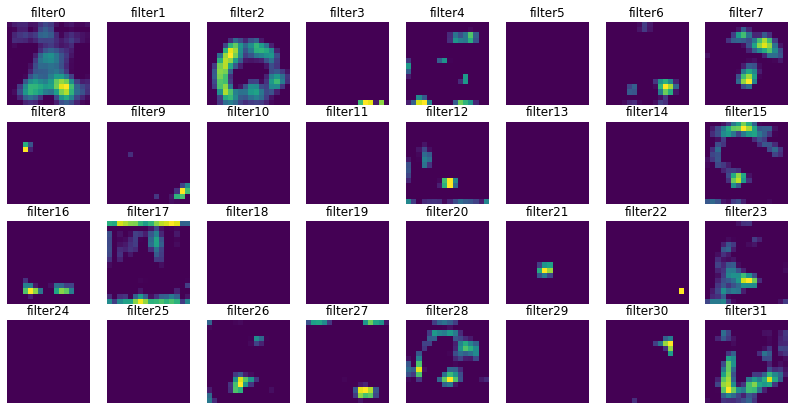

In [ ]:
block5_conv3_output = Model(inputs = base_model.input,
                         outputs = base_model.get_layer('block5_conv3').output)
block5_conv3_features = block5_conv3_output.predict(img)

fig = plt.figure(figsize = (14,7))

print("Convolution Layer - Block 5")
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(block5_conv3_features[0, :, :, i], cmap = 'viridis')
plt.show()

**Model Performance**

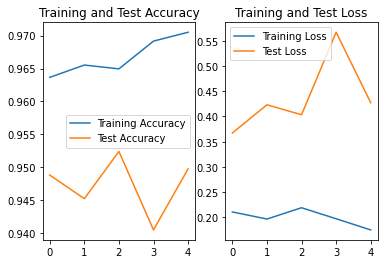

In [ ]:
plt.subplot(1, 2, 1)
plt.title('Training and Test Accuracy')
plt.plot(history_vgg.epoch, history_vgg.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg.epoch, history_vgg.history['val_accuracy'], label='Test Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Training and Test Loss')
plt.plot(history_vgg.epoch, history_vgg.history['loss'], label='Training Loss')
plt.plot(history_vgg.epoch, history_vgg.history['val_loss'], label='Test Loss')
plt.legend()

plt.show()

**Model Evaluation**

In [ ]:
accuracy_score = classifier.evaluate(testing_dataset)

print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))
print("Loss: ",accuracy_score[0])

297/297 [==============================] - 57s 190ms/step - loss: 0.3914 - accuracy: 0.9476
Accuracy: 94.7579%
Loss:  0.39135029911994934


**Classification Report**

In [ ]:
testing_dataset.reset()
predictions = classifier.predict_generator(testing_dataset, steps=len(testing_dataset))

y = np.argmax(predictions, axis=1)

print('Classification Report')
cr = classification_report(y_true=testing_dataset.classes, y_pred=y, target_names=testing_dataset.class_indices)
print(cr)

Classification Report
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.05      0.06      0.05       250
                                 Apple___Black_rot       0.02      0.02      0.02       250
                          Apple___Cedar_apple_rust       0.02      0.02      0.02       250
                                   Apple___healthy       0.02      0.02      0.02       250
                               Blueberry___healthy       0.04      0.04      0.04       250
          Cherry_(including_sour)___Powdery_mildew       0.02      0.02      0.02       250
                 Cherry_(including_sour)___healthy       0.04      0.04      0.04       250
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.01      0.01      0.01       250
                       Corn_(maize)___Common_rust_       0.02      0.02      0.02       250
               Corn_(maize)___Northern_Leaf_Blight       

**Confusion Matrix**

Confusion Matrix


<AxesSubplot:>

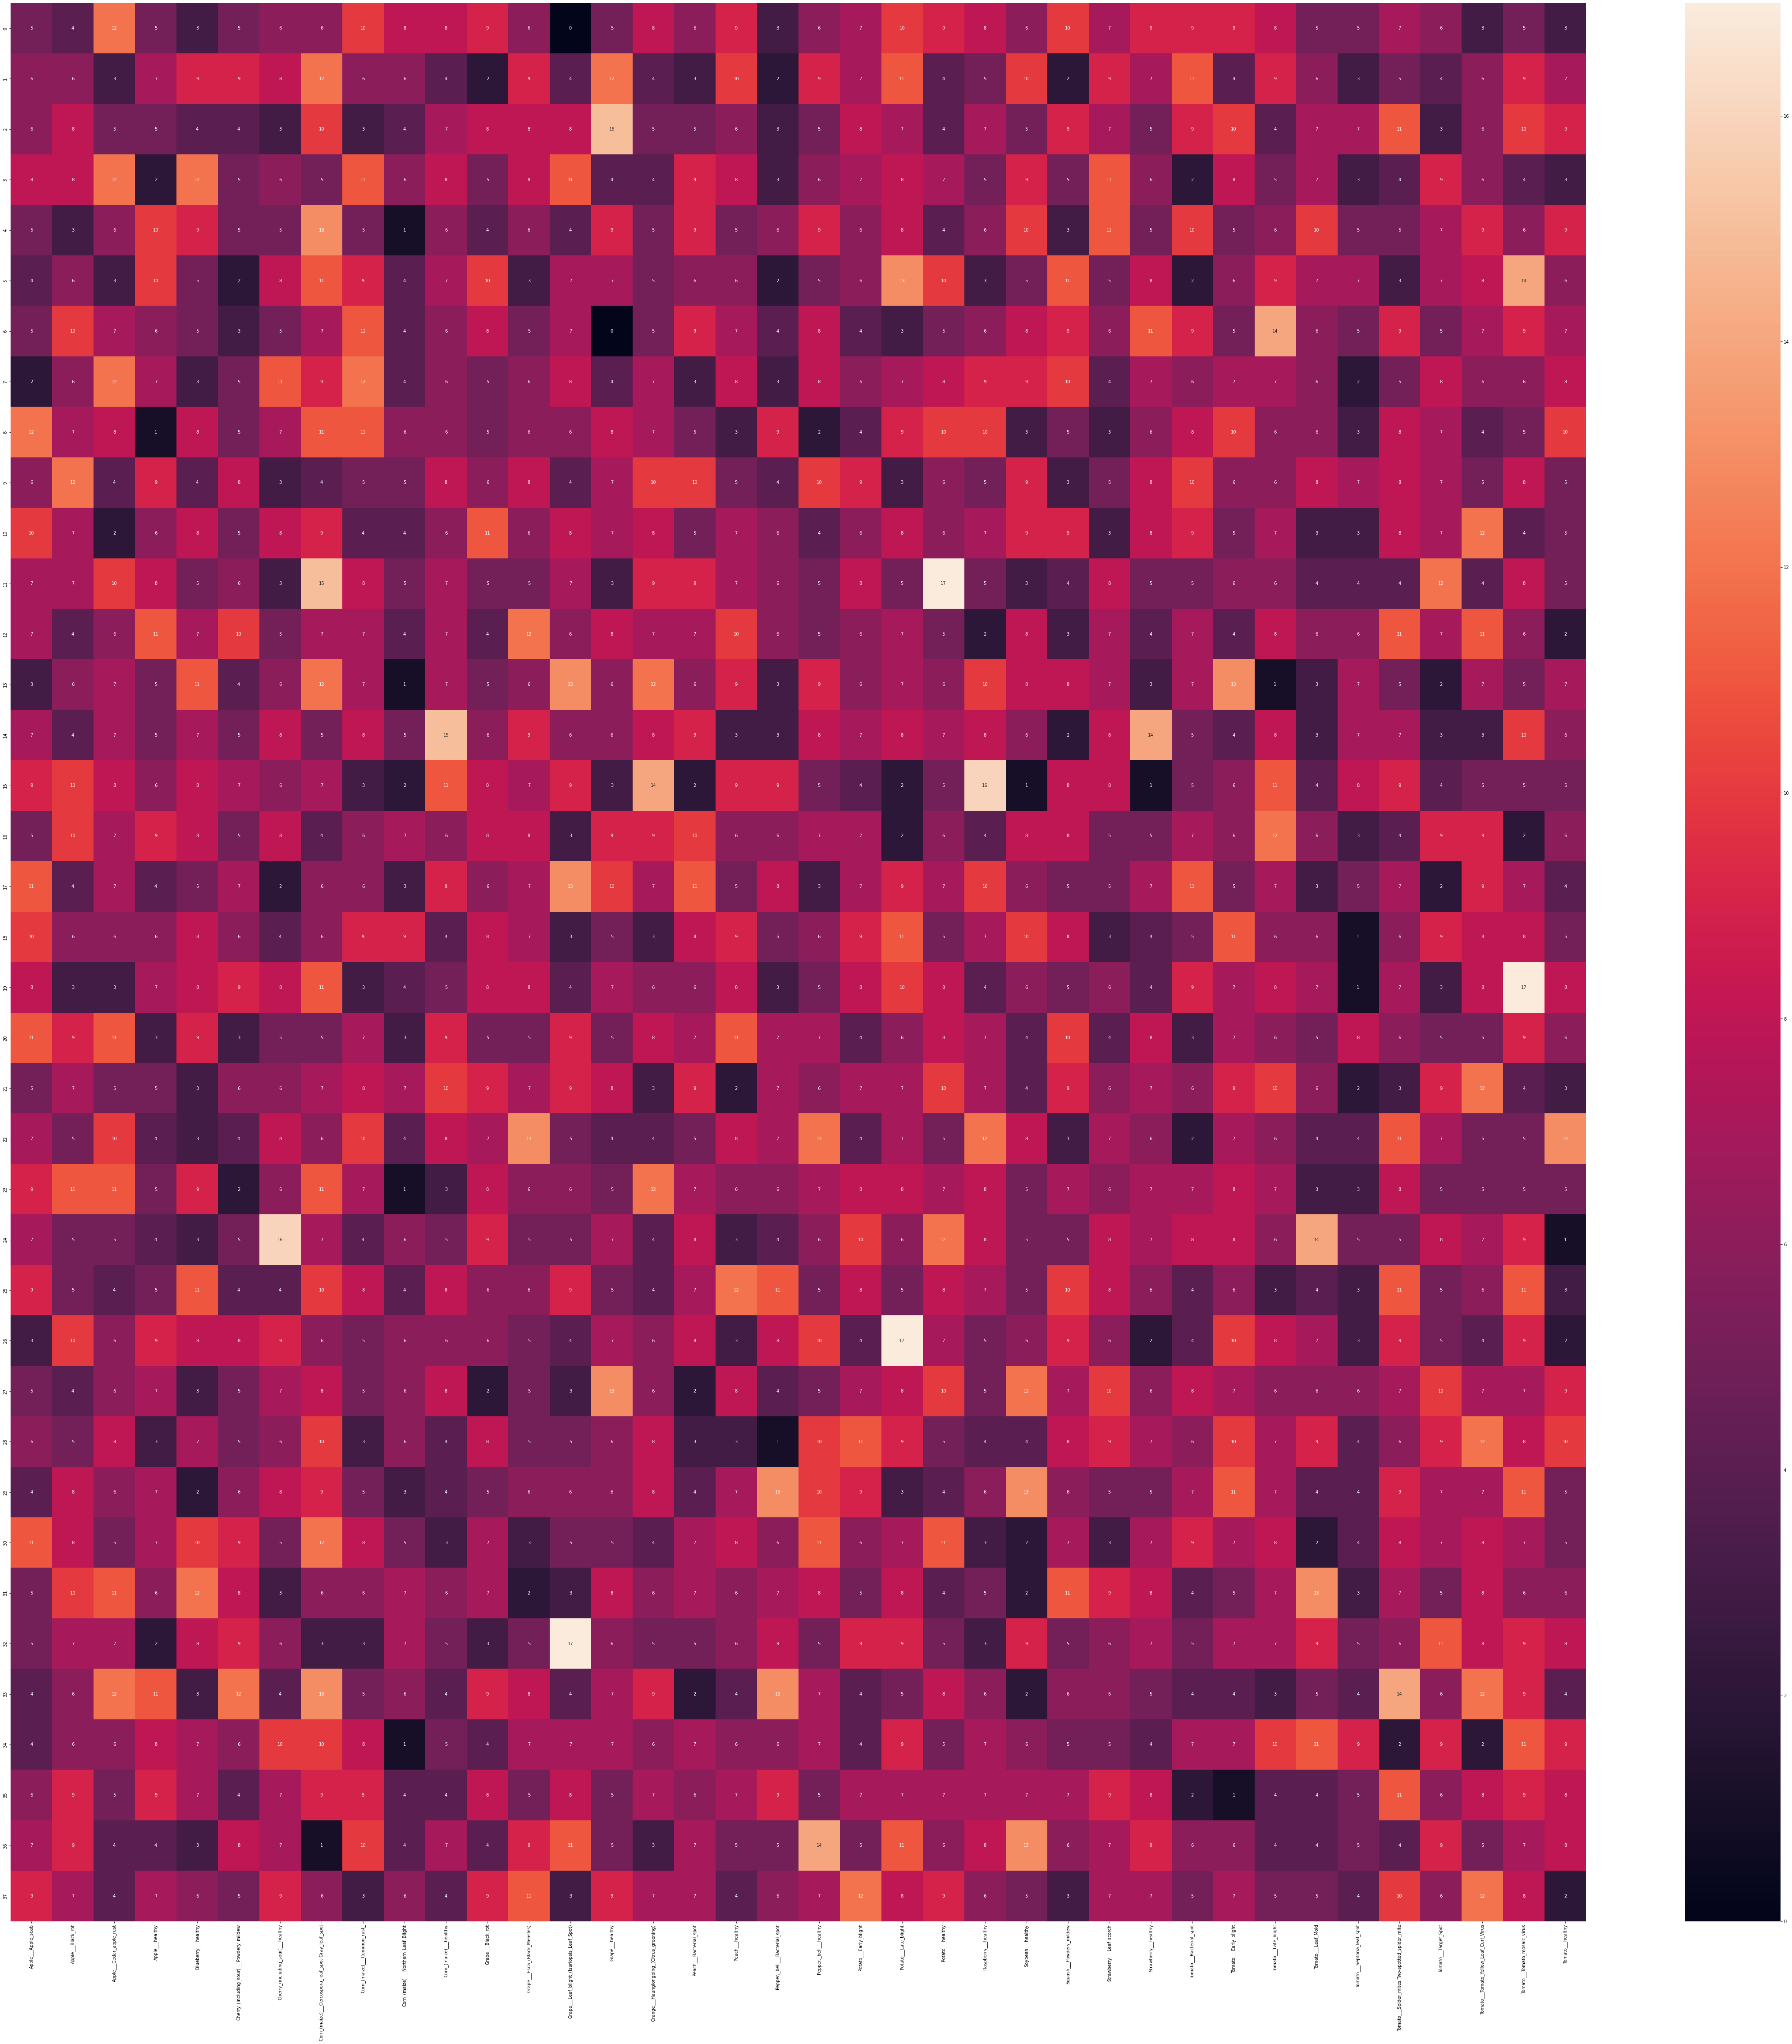

In [ ]:
print('Confusion Matrix')
cm = confusion_matrix(testing_dataset.classes, y)
df = pd.DataFrame(cm, columns=testing_dataset.class_indices)
plt.figure(figsize=(80,80))
sn.heatmap(df, annot=True)

## Part 4 - Making Predictions

In [ ]:
class_dict = training_dataset.class_indices
print("Total classes: ", num_classes)
class_dict

Total classes:  38


{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Blueberry___healthy': 4,
 'Cherry_(including_sour)___Powdery_mildew': 5,
 'Cherry_(including_sour)___healthy': 6,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7,
 'Corn_(maize)___Common_rust_': 8,
 'Corn_(maize)___Northern_Leaf_Blight': 9,
 'Corn_(maize)___healthy': 10,
 'Grape___Black_rot': 11,
 'Grape___Esca_(Black_Measles)': 12,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13,
 'Grape___healthy': 14,
 'Orange___Haunglongbing_(Citrus_greening)': 15,
 'Peach___Bacterial_spot': 16,
 'Peach___healthy': 17,
 'Pepper,_bell___Bacterial_spot': 18,
 'Pepper,_bell___healthy': 19,
 'Potato___Early_blight': 20,
 'Potato___Late_blight': 21,
 'Potato___healthy': 22,
 'Raspberry___healthy': 23,
 'Soybean___healthy': 24,
 'Squash___Powdery_mildew': 25,
 'Strawberry___Leaf_scorch': 26,
 'Strawberry___healthy': 27,
 'Tomato___Bacterial_spot': 28,
 'Tomato___Early_blight': 29,
 'Toma

In [ ]:
# unstable code
list_keys = [
 'Apple - scab',
 'Apple - Black rot',
 'Apple - Cedar apple rust',
 'Apple - healthy',
 'Blueberry - healthy',
 'Cherry(including_sour) - Powdery_mildew',
 'Cherry(including_sour) - healthy',
 'Corn - Cercospora leaf spot Gray leaf spot',
 'Corn - Common rust',
 'Corn - Northern Leaf Blight',
 'Corn - healthy',
 'Grape - Black_rot',
 'Grape - Esca (Black Measles)',
 'Grape - Leaf blight (Isariopsis Leaf Spot)',
 'Grape - healthy',
 'Orange - Haunglongbing (Citrus greening)',
 'Peach - Bacterial spot',
 'Peach - healthy',
 'Pepper bell - Bacterial spot',
 'Pepper bell - healthy',
 'Potato - Early blight',
 'Potato - Late blight',
 'Potato - healthy',
 'Raspberry - healthy',
 'Soybean - healthy',
 'Squash - Powdery mildew',
 'Strawberry - Leaf scorch',
 'Strawberry - healthy',
 'Tomato - Bacterial spot',
 'Tomato - Early blight',
 'Tomato - Late blight',
 'Tomato - Leaf Mold',
 'Tomato - Septoria leaf spot',
 'Tomato - Spider_mites Two-spotted spider mite',
 'Tomato - Target Spot',
 'Tomato - Tomato Yellow Leaf Curl Virus',
 'Tomato - Tomato mosaic virus',
 'Tomato - Healthy'
]

class_dict = dict(zip(list_keys, range(num_classes)))
class_dict

{'Apple - scab': 0,
 'Apple - Black rot': 1,
 'Apple - Cedar apple rust': 2,
 'Apple - healthy': 3,
 'Blueberry - healthy': 4,
 'Cherry(including_sour) - Powdery_mildew': 5,
 'Cherry(including_sour) - healthy': 6,
 'Corn - Cercospora leaf spot Gray leaf spot': 7,
 'Corn - Common rust': 8,
 'Corn - Northern Leaf Blight': 9,
 'Corn - healthy': 10,
 'Grape - Black_rot': 11,
 'Grape - Esca (Black Measles)': 12,
 'Grape - Leaf blight (Isariopsis Leaf Spot)': 13,
 'Grape - healthy': 14,
 'Orange - Haunglongbing (Citrus greening)': 15,
 'Peach - Bacterial spot': 16,
 'Peach - healthy': 17,
 'Pepper bell - Bacterial spot': 18,
 'Pepper bell - healthy': 19,
 'Potato - Early blight': 20,
 'Potato - Late blight': 21,
 'Potato - healthy': 22,
 'Raspberry - healthy': 23,
 'Soybean - healthy': 24,
 'Squash - Powdery mildew': 25,
 'Strawberry - Leaf scorch': 26,
 'Strawberry - healthy': 27,
 'Tomato - Bacterial spot': 28,
 'Tomato - Early blight': 29,
 'Tomato - Late blight': 30,
 'Tomato - Leaf Mold

In [ ]:
li = list(class_dict.keys())
li

['Apple - scab',
 'Apple - Black rot',
 'Apple - Cedar apple rust',
 'Apple - healthy',
 'Blueberry - healthy',
 'Cherry(including_sour) - Powdery_mildew',
 'Cherry(including_sour) - healthy',
 'Corn - Cercospora leaf spot Gray leaf spot',
 'Corn - Common rust',
 'Corn - Northern Leaf Blight',
 'Corn - healthy',
 'Grape - Black_rot',
 'Grape - Esca (Black Measles)',
 'Grape - Leaf blight (Isariopsis Leaf Spot)',
 'Grape - healthy',
 'Orange - Haunglongbing (Citrus greening)',
 'Peach - Bacterial spot',
 'Peach - healthy',
 'Pepper bell - Bacterial spot',
 'Pepper bell - healthy',
 'Potato - Early blight',
 'Potato - Late blight',
 'Potato - healthy',
 'Raspberry - healthy',
 'Soybean - healthy',
 'Squash - Powdery mildew',
 'Strawberry - Leaf scorch',
 'Strawberry - healthy',
 'Tomato - Bacterial spot',
 'Tomato - Early blight',
 'Tomato - Late blight',
 'Tomato - Leaf Mold',
 'Tomato - Septoria leaf spot',
 'Tomato - Spider_mites Two-spotted spider mite',
 'Tomato - Target Spot',
 'To

**Making a single prediction**

Image shape (batch_size, img_widgth, img_height, rgb) :  (1, 256, 256, 3)
1/1 [==============================] - 0s 153ms/step

Model probabilities belonging to each: 
 [1.0000000e+00 1.1406614e-20 4.2046404e-13 1.5589237e-24 8.8710638e-26
 2.5998124e-25 0.0000000e+00 7.9724009e-36 5.4569430e-36 2.6007427e-19
 0.0000000e+00 2.4402160e-29 5.6899976e-35 2.8090577e-36 4.5274362e-28
 1.7212685e-20 2.3555478e-15 0.0000000e+00 1.4022410e-34 5.3109544e-33
 7.0141290e-28 6.2387734e-23 1.4651733e-37 1.8287732e-30 2.8486298e-35
 5.4855407e-27 1.0581936e-32 6.7280910e-31 3.6943315e-25 4.0074366e-25
 7.1724067e-23 5.4514474e-22 2.3694327e-25 3.8171070e-30 1.9305739e-31
 1.2993550e-29 8.5104916e-31 1.0385558e-36]

Class predicted [argmax]:  [0]


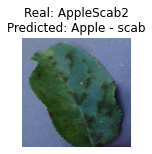

In [ ]:
from keras.utils import load_img
from tensorflow.keras.preprocessing import image

file_name = "AppleScab2.JPG"
image_path = "/content/drive/MyDrive/new-plant-diseases-dataset/predict images/"+file_name
new_img = load_img(image_path, target_size=(img_width,img_height))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255
print("Image shape (batch_size, img_widgth, img_height, rgb) : ", img.shape)
# prediction = [[0]]
prediction = classifier.predict(img)
# img_class = classifier.predict(img)
predict_classes = np.argmax(prediction,axis=1)
print("\nModel probabilities belonging to each: \n", prediction[0]) # [0]
print("\nClass predicted [argmax]: ", predict_classes)

d = prediction.flatten()
j = d.max()
for index,item in enumerate(d):
    if item == j:
        class_name = li[index]

#ploting image with predicted class name
plt.figure(figsize = (2,2))
plt.imshow(new_img)
plt.axis('off')
plt.title("Real: "+file_name[:-4]+"\nPredicted: "+class_name)
plt.show()

**Making a batch prediction**

In [ ]:
def func_plot_img(image, file_name, class_name, position):
    fig.add_subplot(rows, columns, position)
    plt.imshow(image)
    plt.axis('off')
    plt.title("True: "+file_name+"\nPredicted: "+class_name)


def img_processing(file_path):
    new_img = load_img(file_path, target_size=(img_width,img_height))
    img = img_to_array(new_img)
    img = np.expand_dims(img, axis=0)
    img = img/255

    prediction = classifier.predict(img)
    predict_classes = np.argmax(prediction,axis=1)

    d = prediction.flatten()
    j = d.max()
    for index,item in enumerate(d):
        if item == j:
            class_name = li[index]

    return new_img, class_name

[8, 2, 6, 0]
['TomatoYellowCurlVirus4.JPG', 'CornCommonRust2.JPG', 'TomatoEarlyBlight6.JPG', 'AppleCedarRust3.JPG'] 

1/1 [==============================] - 0s 23ms/step


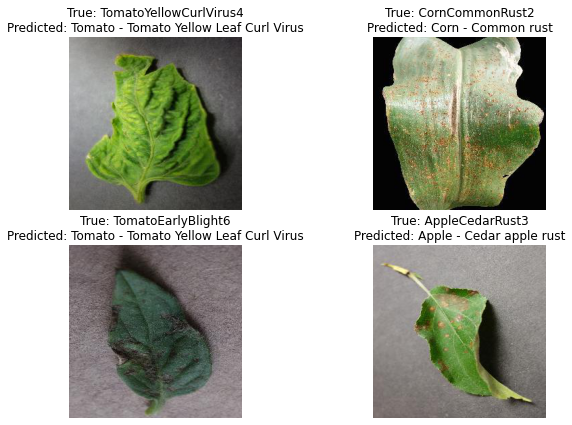

In [ ]:
# showing predictions for 4 random images in the directory
import os

image_path = "/content/drive/MyDrive/new-plant-diseases-dataset/predict images/"
image_names = os.listdir(image_path)

rand_list = list(random.sample(range(0, len(image_names)), 4))
# rand_list = [8, 13, 6, 0]
print(rand_list)
print([image_names[i] for i in rand_list], "\n")

rows = columns = 2
fig = plt.figure(figsize=(10, 7))

pos = 1
for file_name_index in rand_list:
    file_name = image_names[file_name_index]
    image, class_name = img_processing(image_path+file_name)

    func_plot_img(image, file_name[:-4], class_name, pos)
    pos += 1